In [20]:
using Plots; pyplot();
using DelimitedFiles;
using AugmentedGaussianProcesses;

In [21]:
X = readdlm("data/banana_X_train");
Y = readdlm("data/banana_Y_train")[:];

In [22]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{GP}(undef,length(Ms)+1)
kernel = RBFKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    m = SVGP(X, Y, kernel,AugmentedLogisticLikelihood(),AnalyticInference(),m,Autotuning=true)
    println("Training with $(num_inducing) points")
    @time train!(m,iterations=20)
    models[index]=m;
end

Training with 4 points
  0.024294 seconds (22.63 k allocations: 27.071 MiB, 12.74% gc time)
Training with 8 points
  0.043008 seconds (22.72 k allocations: 43.684 MiB, 14.93% gc time)
Training with 16 points
  0.059324 seconds (22.89 k allocations: 77.025 MiB, 12.42% gc time)
Training with 32 points
  0.068900 seconds (23.24 k allocations: 144.194 MiB, 23.05% gc time)
Training with 64 points
  0.370701 seconds (24.11 k allocations: 280.451 MiB, 8.60% gc time)


In [23]:
mfull = VGP(X, Y, kernel,AugmentedLogisticLikelihood(),AnalyticInference(),Autotuning=true)
train!(mfull,iterations=5);
models[end] = mfull;

In [24]:
function compute_Grid(model,nGrid=50)
    mins = [-3.25,-2.85]
    maxs = [3.65,3.4]
    xlin = range(mins[1],stop=maxs[1],length=nGrid)
    ylin = range(mins[2],stop=maxs[2],length=nGrid)
    Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y =  proba_y(model,Xplot)
    return (y,xlin,ylin)
    end;

In [25]:
function plotdata(X,Y)
    plot(X[Y.==1,1],X[Y.==1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
    plot!(X[Y.==-1,1],X[Y.==-1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="")
    end;

In [18]:
function plotcontour(model,X,Y)
    nGrid = 40
    (predic,x,y) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:Z,fieldnames(typeof(model)))
        println("Plotting model with $(model.m) points")
        plot!(model.Z[1][:,1],model.inducingPoints.Z[1][:,2],msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,y,reshape(predic,nGrid,nGrid),cbar=false,t=:contour,levels=[0.5],fill=false,fillalpha=0.2,title=(in(:m,fieldnames(typeof(model))) ? "M = $(model.nInducingPoints)" : "full"))
end;

Plotting model with 4 points
Plotting model with 8 points
Plotting model with 16 points
Plotting model with 32 points
Plotting model with 64 points


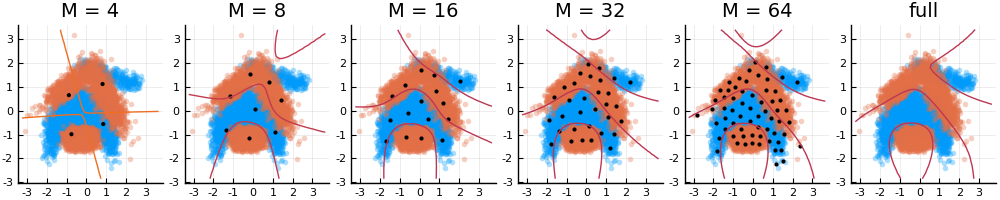

In [19]:
plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))